<a href="https://colab.research.google.com/github/WhiteFox-Lugh/Pratice-TextAnalysis/blob/master/exercise2A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 情報システム論実習　テキスト分析　課題2A

## import

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import collections
from gensim import models
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [2]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("reuters")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### データを取得

今回は nltk の reuters を使用する

In [3]:
from nltk.corpus import reuters as corpus

### 全 document 数の確認

In [4]:
len(corpus.fileids())

10788

### 前から k 文書とってくる

In [5]:
k = 2000
docs = [corpus.words(fileid) for fileid in corpus.fileids()[:k]]
tag_arr = corpus.fileids()[:k]
print(tag_arr)

['test/14826', 'test/14828', 'test/14829', 'test/14832', 'test/14833', 'test/14839', 'test/14840', 'test/14841', 'test/14842', 'test/14843', 'test/14844', 'test/14849', 'test/14852', 'test/14854', 'test/14858', 'test/14859', 'test/14860', 'test/14861', 'test/14862', 'test/14863', 'test/14865', 'test/14867', 'test/14872', 'test/14873', 'test/14875', 'test/14876', 'test/14877', 'test/14881', 'test/14882', 'test/14885', 'test/14886', 'test/14888', 'test/14890', 'test/14891', 'test/14892', 'test/14899', 'test/14900', 'test/14903', 'test/14904', 'test/14907', 'test/14909', 'test/14911', 'test/14912', 'test/14913', 'test/14918', 'test/14919', 'test/14921', 'test/14922', 'test/14923', 'test/14926', 'test/14928', 'test/14930', 'test/14931', 'test/14932', 'test/14933', 'test/14934', 'test/14941', 'test/14943', 'test/14949', 'test/14951', 'test/14954', 'test/14957', 'test/14958', 'test/14959', 'test/14960', 'test/14962', 'test/14963', 'test/14964', 'test/14965', 'test/14967', 'test/14968', 'test

### カテゴリーのチェック

最初の5文書のカテゴリー

In [6]:
for i in range(5):
  t = tag_arr[i]
  print(corpus.categories(t))

['trade']
['grain']
['crude', 'nat-gas']
['corn', 'grain', 'rice', 'rubber', 'sugar', 'tin', 'trade']
['palm-oil', 'veg-oil']


文書名 -> カテゴリーのディクショナリを作成

In [7]:
docs_category = {}
for i in range(len(corpus.fileids()[:k])):
  cat = tag_arr[i]
  docs_category[cat] = corpus.categories(cat)

## 前処理

### nltkのストップワードリスト

In [8]:
en_stop = nltk.corpus.stopwords.words('english')

In [13]:
en_stop= ["``","/",",.",".,",";","--",":",")","(",'"','&',"'",'),',',"','-','.,','.,"','.-',"?",">","<"] + ["said","say","u","v","mln","ct","net","dlrs","tonne","pct","shr","nil","company","lt","share","year","billion","price"] + en_stop

### 前処理関数の作成

In [14]:
from nltk.corpus import wordnet as wn #lemmatize関数のためのimport

def preprocess_word(word, stopwordset):
    
    #1.make words lower ex: Python =>python
    word=word.lower()

    #2. remove number
    try:
      word = int(word)
      return None
    except:
      pass
    
    #3.remove "," and "."
    if word in [",","."]:
        return None
    
    #4.remove stopword  ex: the => (None) 
    if word in stopwordset:
        return None
    
    #5.lemmatize  ex: cooked=>cook
    lemma = wn.morphy(word)
    if lemma is None:
        return word

    elif lemma in stopwordset: #lemmatizeしたものがstopwordである可能性がある
        return None
    else:
        return lemma
    

def preprocess_document(document):
    document=[preprocess_word(w, en_stop) for w in document]
    document=[w for w in document if w is not None]
    return document

def preprocess_documents(documents):
    return [preprocess_document(document) for document in documents]

### 前処理の結果を出力してみる

### 前処理前

In [15]:
print(docs[1][:100]) 

['CHINA', 'DAILY', 'SAYS', 'VERMIN', 'EAT', '7', '-', '12', 'PCT', 'GRAIN', 'STOCKS', 'A', 'survey', 'of', '19', 'provinces', 'and', 'seven', 'cities', 'showed', 'vermin', 'consume', 'between', 'seven', 'and', '12', 'pct', 'of', 'China', "'", 's', 'grain', 'stocks', ',', 'the', 'China', 'Daily', 'said', '.', 'It', 'also', 'said', 'that', 'each', 'year', '1', '.', '575', 'mln', 'tonnes', ',', 'or', '25', 'pct', ',', 'of', 'China', "'", 's', 'fruit', 'output', 'are', 'left', 'to', 'rot', ',', 'and', '2', '.', '1', 'mln', 'tonnes', ',', 'or', 'up', 'to', '30', 'pct', ',', 'of', 'its', 'vegetables', '.', 'The', 'paper', 'blamed', 'the', 'waste', 'on', 'inadequate', 'storage', 'and', 'bad', 'preservation', 'methods', '.', 'It', 'said', 'the', 'government']


### 前処理後

In [16]:
print(preprocess_documents(docs)[1][:100])

['china', 'daily', 'vermin', 'eat', 'grain', 'stocks', 'a', 'survey', 'of', 'province', 'and', 'seven', 'city', 'show', 'vermin', 'consume', 'between', 'seven', 'and', 'of', 'china', 's', 'grain', 'stocks', 'the', 'china', 'daily', 'it', 'also', 'that', 'each', 'or', 'of', 'china', 's', 'fruit', 'output', 'are', 'left', 'to', 'rot', 'and', 'or', 'up', 'to', 'of', 'it', 'vegetable', 'the', 'paper', 'blame', 'the', 'waste', 'on', 'inadequate', 'storage', 'and', 'bad', 'preservation', 'method', 'it', 'the', 'government', 'have', 'launch', 'a', 'national', 'programme', 'to', 'reduce', 'waste', 'calling', 'for', 'improve', 'technology', 'in', 'storage', 'and', 'preservation', 'and', 'greater', 'production', 'of', 'additive', 'the', 'paper', 'give', 'no', 'further', 'details']


## クラスタリング

### doc2vec の準備

In [17]:
pre_docs=preprocess_documents(docs)
labeled_sentence = [TaggedDocument(words = pre_docs[n], tags = [tag_arr[n]]) 
                    for n in range(k)]
print(labeled_sentence)

[TaggedDocument(words=['asian', 'exporter', 'fear', 'damage', 'from', 's', 'japan', 'rift', 'mounting', 'trade', 'friction', 'between', 'the', 's', 'and', 'japan', 'ha', 'raise', 'fear', 'among', 'many', 'of', 'asia', 's', 'exporting', 'nation', 'that', 'the', 'row', 'could', 'inflict', 'far', 'reaching', 'economic', 'damage', 'businessmen', 'and', 'official', 'they', 'tell', 'reuter', 'correspondent', 'in', 'asian', 'capital', 'a', 's', 'move', 'against', 'japan', 'might', 'boost', 'protectionist', 'sentiment', 'in', 'the', 's', 'and', 'lead', 'to', 'curb', 'on', 'american', 'import', 'of', 'their', 'product', 'but', 'some', 'exporter', 'that', 'while', 'the', 'conflict', 'would', 'hurt', 'them', 'in', 'the', 'long', 'run', 'in', 'the', 'short', 'term', 'tokyo', 's', 'loss', 'might', 'be', 'their', 'gain', 'the', 's', 'ha', 'it', 'will', 'impose', 'of', 'tariff', 'on', 'import', 'of', 'japanese', 'electronics', 'good', 'on', 'april', 'in', 'retaliation', 'for', 'japan', 's', 'allege',

In [18]:
# モデルの定義
# dm : 1 なら PV-DM を使い、0 なら PV-DBOW を使う
# vector_size : 特徴ベクトルの次元数
# windows : 前後何単語とるか
# min_count : total frequency がこれ未満なら単語を無視する（今回は無視しない）
# alpha : 学習率
model = Doc2Vec(documents = labeled_sentence, dm = 1, vector_size = 50,
                windows = 5, min_count = 1, alpha = 0.0015)

### fitする

In [20]:
# document size の再確認
print(len(pre_docs))

# k-means の入力にする
vecs = [model.docvecs[i] for i in range(len(model.docvecs))]
doc_prefix = [(pre_docs[i][0] + " " + pre_docs[i][1] + " ...") for i in range(len(model.docvecs))]

print(tag_arr[0])
print(doc_prefix[0])
print(vecs[0])

2000
test/14826
asian exporter ...
[-0.0078062  -0.00136335  0.00082224  0.00245977 -0.01293217  0.00942804
  0.00490445  0.00865303 -0.00688881  0.00234782  0.00410943 -0.00995311
 -0.00510409 -0.00092575 -0.01164708 -0.00160321  0.00963002 -0.00354489
  0.00431378 -0.00282388 -0.00615691  0.00019788 -0.00445585  0.00127433
  0.01303635 -0.00073575  0.01424438 -0.00906212 -0.01018051 -0.00539334
  0.00193517 -0.01333271 -0.01074414 -0.00377423  0.00461969  0.0029106
 -0.00099628 -0.00681582 -0.00780498  0.00841734  0.0066565  -0.00452645
  0.00833856 -0.00328049 -0.0019831   0.01682866  0.00020162  0.00659482
 -0.00027455  0.01273943]


### tf-idf

In [21]:
pre_docs=preprocess_documents(docs)
pre_docs=[" ".join(doc) for doc in pre_docs]
print(pre_docs[0])

vectorizer = TfidfVectorizer(max_features=50, token_pattern=u'(?u)\\b\\w+\\b' )
tf_idf = vectorizer.fit_transform(pre_docs)

asian exporter fear damage from s japan rift mounting trade friction between the s and japan ha raise fear among many of asia s exporting nation that the row could inflict far reaching economic damage businessmen and official they tell reuter correspondent in asian capital a s move against japan might boost protectionist sentiment in the s and lead to curb on american import of their product but some exporter that while the conflict would hurt them in the long run in the short term tokyo s loss might be their gain the s ha it will impose of tariff on import of japanese electronics good on april in retaliation for japan s allege failure to stick to a pact not to sell semiconductor on world market at below cost unofficial japanese estimate put the impact of the tariff at and spokesman for major electronics firm they would virtually halt export of product hit by the new tax we wouldn t be able to do business a spokesman for leading japanese electronics firm matsushita electric industrial 

### K-means
### kmeansの設定

In [23]:
def fun_kmeans(n, v_input):
  # k-means definition
  # n_clusters : クラスタ数
  km = KMeans(n_clusters = n, max_iter = 300, n_init = 10,
              init = 'k-means++', random_state = 0)
  ret = km.fit_predict(v_input)
  ret2 = km.inertia_
  return ret, ret2

In [24]:
def cluster_counter(n, v_len, clusters_res):
  # クラスタごとのカウント
  cnt = np.zeros(n)

  for j in range(v_len):
    c = clusters_res[j]
    cnt[c] += 1

  print(cnt)
  return

In [25]:
def show_category(n, cls_res):
  for j in range(n):
    print("Cluster num : " + str(j))
    l = []
    for doc, cls in zip(tag_arr, cls_res):
      if not cls == j:
        continue
      category_arr = docs_category[doc]
      l.extend(category_arr)
    c = collections.Counter(l)
    print(c)
  return

### k-means の k を様々な値にして回す

#### doc2vec

In [26]:
x = np.empty(0)
y = np.empty(0)

for i in range(1, 16, 1):
  print("Cluster Nums -> " + str(i))
  # モデル定義 / fit
  clusters, sse = fun_kmeans(i, vecs)

  # クラスタリング結果表示（数）
  cluster_counter(i, len(vecs), clusters)

  # タグの表示
  show_category(i, clusters)

  # SSE の表示
  print("Distortion : %.5f"% sse)

  # plot 用
  x = np.append(x, i)
  y = np.append(y, sse)

  print("==========================\n")

Cluster Nums -> 1
[2000.]
Cluster num : 0
Counter({'earn': 633, 'acq': 490, 'grain': 118, 'money-fx': 108, 'crude': 105, 'interest': 91, 'trade': 89, 'wheat': 58, 'ship': 45, 'corn': 44, 'dlr': 37, 'oilseed': 34, 'gnp': 32, 'sugar': 30, 'money-supply': 30, 'veg-oil': 27, 'nat-gas': 25, 'soybean': 23, 'bop': 23, 'gold': 22, 'cpi': 22, 'rice': 20, 'livestock': 19, 'alum': 19, 'coffee': 18, 'jobs': 17, 'meal-feed': 17, 'reserves': 16, 'copper': 15, 'gas': 15, 'cocoa': 15, 'carcass': 14, 'cotton': 14, 'barley': 13, 'lead': 12, 'iron-steel': 12, 'tin': 11, 'soy-oil': 11, 'yen': 11, 'strategic-metal': 11, 'orange': 11, 'soy-meal': 11, 'zinc': 10, 'sorghum': 10, 'pet-chem': 10, 'wpi': 10, 'palm-oil': 9, 'ipi': 8, 'fuel': 8, 'rubber': 7, 'platinum': 7, 'income': 7, 'rapeseed': 6, 'silver': 6, 'lumber': 5, 'heat': 5, 'oat': 5, 'groundnut': 4, 'hog': 4, 'rape-oil': 3, 'potato': 3, 'lei': 3, 'sunseed': 2, 'sun-oil': 2, 'retail': 2, 'cotton-oil': 2, 'tea': 2, 'coconut-oil': 2, 'dmk': 2, 'naphtha':

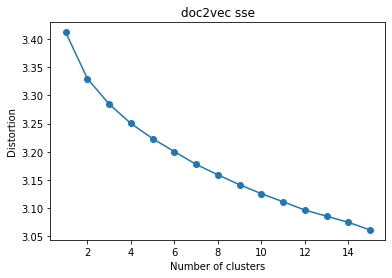

In [27]:
# エルボー法の plot
plt.plot(x, y, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title("doc2vec sse")
plt.show()

#### tf-idf

In [28]:
x = np.empty(0)
y = np.empty(0)

for i in range(1, 16, 1):
  print("Cluster Nums -> " + str(i))
  # モデル定義 / fit
  clusters, sse = fun_kmeans(i, tf_idf)

  # クラスタリング結果表示（数）
  cluster_counter(i, np.shape(tf_idf)[0], clusters)

  # タグの表示
  show_category(i, clusters)

  # SSE の表示
  print("Distortion : %.5f"% sse)

  # plot 用
  x = np.append(x, i)
  y = np.append(y, sse)

  print("==========================\n")

Cluster Nums -> 1
[2000.]
Cluster num : 0
Counter({'earn': 633, 'acq': 490, 'grain': 118, 'money-fx': 108, 'crude': 105, 'interest': 91, 'trade': 89, 'wheat': 58, 'ship': 45, 'corn': 44, 'dlr': 37, 'oilseed': 34, 'gnp': 32, 'sugar': 30, 'money-supply': 30, 'veg-oil': 27, 'nat-gas': 25, 'soybean': 23, 'bop': 23, 'gold': 22, 'cpi': 22, 'rice': 20, 'livestock': 19, 'alum': 19, 'coffee': 18, 'jobs': 17, 'meal-feed': 17, 'reserves': 16, 'copper': 15, 'gas': 15, 'cocoa': 15, 'carcass': 14, 'cotton': 14, 'barley': 13, 'lead': 12, 'iron-steel': 12, 'tin': 11, 'soy-oil': 11, 'yen': 11, 'strategic-metal': 11, 'orange': 11, 'soy-meal': 11, 'zinc': 10, 'sorghum': 10, 'pet-chem': 10, 'wpi': 10, 'palm-oil': 9, 'ipi': 8, 'fuel': 8, 'rubber': 7, 'platinum': 7, 'income': 7, 'rapeseed': 6, 'silver': 6, 'lumber': 5, 'heat': 5, 'oat': 5, 'groundnut': 4, 'hog': 4, 'rape-oil': 3, 'potato': 3, 'lei': 3, 'sunseed': 2, 'sun-oil': 2, 'retail': 2, 'cotton-oil': 2, 'tea': 2, 'coconut-oil': 2, 'dmk': 2, 'naphtha':

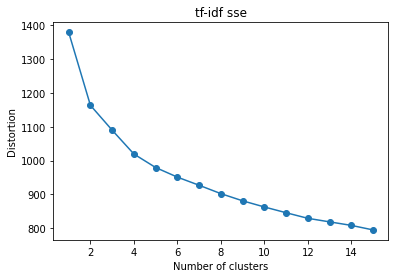

In [29]:
# エルボー法の plot
plt.plot(x, y, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title("tf-idf sse")
plt.show()